In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install SimpleITK

In [3]:
import sys
sys.path.append('/content/drive/My Drive/Luan Van 2019/Tumor/model/src')
from util.metrics import *
from util.data import *
from util.evaluate_model_tools import *
from model import cnn
import glob
import gc
import csv

Using TensorFlow backend.


# Function use

In [0]:
def crop_to_original_size(image,original_size):
    image = image[0:original_size[0], 0:original_size[1], 0:original_size[2]]
    return image

Predict in scan (192,192,64)

In [0]:
def scan_predict(scan_to_process, model, batch_size, fragment_size, verbose = 0):
    crop_scans, factor = crop_scan(scan_to_process, fragment_size)
    crop_scans = np.reshape(crop_scans, crop_scans.shape + (1,))
    output = model.predict(crop_scans, batch_size = batch_size,verbose = verbose)[:,:,:,:,0]
    return rebuild_scan(output, factor, fragment_size)

In [0]:
def rebuild_scan(images, factor, fragment_size):
    '''
    rebuild image from many fragment and crop to original size
    :param images: input list (array) of fragment image)
    :param factor: number of fragment per dimension
    :param fragment_size:
    :return: output image array
    '''
    image = np.zeros(factor * fragment_size, dtype=images.dtype)
    for index in range(0, len(images)):
        i, j, k = to3D(index, factor)
        image[i * fragment_size[0]:(i + 1) * fragment_size[0], j * fragment_size[1]:(j + 1) * fragment_size[1],
        k * fragment_size[2]:(k + 1) * fragment_size[2]] = images[index]
    return image

Predict 1 sample

In [0]:
def predict_Sample(input_scan_arr, model, target_size, batch_size , verbose = 0):
    gc.collect()
    original_size = input_scan_arr.shape
    scan_arr = padding_scan(input_scan_arr, target_size)
    print("original_size",original_size)
    print("scan_arr size",scan_arr.shape)
    #additional predictions
    predicted_output = scan_predict(scan_to_process = scan_arr, model = model, batch_size = batch_size, fragment_size = target_size, verbose = verbose)
    predicted_label = crop_to_original_size(predicted_output,original_size)
    return predicted_label

Function to evaluate

In [0]:
def compute_DICE(y_true, y_pred, smooth=1e-8):
    itersection = np.sum(np.logical_and(y_pred, y_true))
    union = np.sum(np.logical_or(y_pred, y_true))
    DICE = (2*itersection + smooth) / (union + itersection + smooth)
    return 100 * DICE
def compute_VOE(y_true, y_pred, smooth=1e-8):
    IOU = (np.sum(np.logical_and(y_pred, y_true)) + smooth) / (np.sum(np.logical_or(y_pred, y_true)) + smooth)
    return 100 * (1 - IOU)

# Predict 1 image

In [0]:
from functools import reduce
def predict_image(path_img,path_gt,checkpoint_path,threshold=None,save_dir=None,evaluate=False, show_slice=None, verbose=False):
  # read image
  image_itk = sitk.ReadImage(path_img)
  spacing_img = image_itk.GetSpacing()
  img_array= sitk.GetArrayFromImage(image_itk)
  image = np.moveaxis(img_array,0,-1)

  gt_itk = sitk.ReadImage(path_gt)
  spacing_gt = gt_itk.GetSpacing()
  gt_array= sitk.GetArrayFromImage(gt_itk)
  gt = np.moveaxis(gt_array,0,-1)

  image_itk2 = sitk.ReadImage("/content/drive/My Drive/DataSet/Nii_data_resample_spacing/"+ path_img[-17:-1]+ path_img[-1])
  img_array2= sitk.GetArrayFromImage(image_itk2)
  image2 = np.moveaxis(img_array2,0,-1)

  print("Load image: ",path_img)
  print("Load mask: ",path_gt)

  # Load and predict for liver
  model_liver=cnn.CNN(size=(192,192,64),base_n_filter = 16, output_activation_name='sigmoid', is_training = False
                ,checkpoint_path = "/content/drive/My Drive/Luan Van 2019/Tumor/weights/CNN_all_final.hdf5")
  predict_liver=predict_Sample(image2, model_liver, target_size=(192,192,64), batch_size=1, verbose = True)


  # Load model
  model=cnn.CNN(size=(64,64,64),base_n_filter = 16, output_activation_name='sigmoid', is_training = False
                ,checkpoint_path = checkpoint_path)
  predict_tumor=predict_Sample(image, model, target_size=(64,64,64), batch_size=1, verbose = True)


  if verbose:
    print("Min value in predicted image: ",predict_tumor.min())
    print("Max value in predicted image: ", predict_tumor.max())
  
  #threshold
  if threshold!=None:
    predict_tumor[predict_tumor>= threshold]=1
    predict_tumor[predict_tumor< threshold]=0
    predict_liver[predict_liver>0.8]=1
    predict_liver[predict_liver<=0.8]=0

  predict_img=np.multiply(predict_tumor,predict_liver)

  if predict_img.sum()<400:
    predict_img[predict_img==1]=0


  #show slice
  if show_slice!=None:
    for i in show_slice:
      print("=======================================")
      print("The slice ",i)
      plt.imshow(image[:,:, i],cmap="gray")
      plt.show()
      plt.imshow(predict_tumor[:,:,i],cmap="gray")
      plt.show()
      plt.imshow(predict_img[:,:,i],cmap="gray")
      plt.show()
      plt.imshow(gt[:,:,i],cmap="gray")
      plt.show()
      print(compute_DICE(gt[:,:,i],predict_img[:,:,i]))

  if evaluate:
    VOE=compute_VOE(gt,predict_img)
    Dice=compute_DICE(gt,predict_img)
    
    sample_voe = compute_VOE(gt,predict_img)
    sample_vd = compute_VD(gt,predict_img)
    #gt_surface_vert = get_surface_vert(gt,spacing=spacing_gt)
    #segm_surface_vert = get_surface_vert(predict_img,spacing_img)
    #sample_avgD, sample_RMSD, sample_maxD = compute_AvgD_RMSD_MaxD(gt_surface_vert,segm_surface_vert)
    sample_dice_score = compute_DICE(gt,predict_img)
    result = [np.around(sample_dice_score,2),np.around(sample_voe,2),np.around(sample_vd,2)]
    if verbose:
      print("VOE = ",VOE)
      print("Dice = ", Dice)
  return result,predict_img,gt


In [0]:
#unet model
def predict_image_unet(path_img,path_gt,checkpoint_path,threshold=None,save_dir=None,evaluate=False, show_slice=None, verbose=False):
  # read image
  image_itk = sitk.ReadImage(path_img)
  img_array= sitk.GetArrayFromImage(image_itk)
  image = np.moveaxis(img_array,0,-1)

  gt_itk = sitk.ReadImage(path_gt)
  gt_array= sitk.GetArrayFromImage(gt_itk)
  gt = np.moveaxis(gt_array,0,-1)

  image_itk2 = sitk.ReadImage("/content/drive/My Drive/DataSet/Nii_data_resample_spacing/"+ path_img[-17:-1]+ path_img[-1])
  img_array2= sitk.GetArrayFromImage(image_itk2)
  image2 = np.moveaxis(img_array2,0,-1)


  print("Load image: ",path_img)
  print("Load mask: ",path_gt)


  # Load and predict for liver
  model_liver=cnn.CNN(size=(192,192,64),base_n_filter = 16, output_activation_name='sigmoid', is_training = False
                ,checkpoint_path = "/content/drive/My Drive/Luan Van 2019/Tumor/weights/CNN_all_final.hdf5")
  predict_liver=predict_Sample(image2, model_liver, target_size=(192,192,64), batch_size=1, verbose = True)

  
  # Load model
  model=cnn.Unet3D_release(size=(64,64,64),base_n_filter = 16, output_activation_name='sigmoid'
                ,Unet3D_weights_path = checkpoint_path)
  predict_tumor=predict_Sample(image, model, target_size=(64,64,64), batch_size=16, verbose = True)

 
  if verbose:
    print("Min value in predicted image: ",predict_tumor.min())
    print("Max value in predicted image: ", predict_tumor.max())
  
  #threshold
  #threshold
  if threshold!=None:
    predict_tumor[predict_tumor>= threshold]=1
    predict_tumor[predict_tumor< threshold]=0
    predict_liver[predict_liver>0.8]=1
    predict_liver[predict_liver<=0.8]=0

  predict_img=np.multiply(predict_tumor,predict_liver)
  print("pixel in list",predict_img.sum())
  #if predict_img.sum()<500:
    #predict_img[predict_img==1]=0

  #show slice
  if show_slice!=None:
    for i in show_slice:
      print("=======================================")
      print("The slice ",i)
      plt.imshow(image[:,:, i],cmap="gray")
      plt.show()
      plt.imshow(predict_tumor[:,:,i],cmap="gray")
      plt.show()
      plt.imshow(predict_img[:,:,i],cmap="gray")
      plt.show()
      plt.imshow(gt[:,:,i],cmap="gray")
      plt.show()
      print(compute_DICE(gt[:,:,i],predict_img[:,:,i]))

  if evaluate:
    VOE=compute_VOE(gt,predict_img)
    Dice=compute_DICE(gt,predict_img)
    if verbose:
      print("VOE = ",VOE)
      print("Dice = ", Dice)
  return VOE,Dice,predict_img


In [0]:
#unet model
def predict_image_unet2(path_img,path_gt,checkpoint_path,threshold=None,save_dir=None,evaluate=False, show_slice=None, verbose=False):
  # read image
  image_itk = sitk.ReadImage(path_img)
  img_array= sitk.GetArrayFromImage(image_itk)
  image = np.moveaxis(img_array,0,-1)

  gt_itk = sitk.ReadImage(path_gt)
  gt_array= sitk.GetArrayFromImage(gt_itk)
  gt = np.moveaxis(gt_array,0,-1)

  image_itk2 = sitk.ReadImage("/content/drive/My Drive/DataSet/Nii_data_resample_spacing/"+ path_img[-17:-1]+ path_img[-1])
  img_array2= sitk.GetArrayFromImage(image_itk2)
  image2 = np.moveaxis(img_array2,0,-1)


  print("Load image: ",path_img)
  print("Load mask: ",path_gt)


  # Load and predict for liver
  model_liver=cnn.CNN(size=(192,192,64),base_n_filter = 16, output_activation_name='sigmoid', is_training = False
                ,checkpoint_path = "/content/drive/My Drive/Luan Van 2019/Tumor/weights/CNN_all_final.hdf5")
  predict_liver=predict_Sample(image2, model_liver, target_size=(192,192,64), batch_size=1, verbose = True)

  tumor_index=np.where(predict_liver== 1)
  maxidx = np.max(tumor_index,axis=1)
  minidx = np.min(tumor_index,axis=1)
  image_predict_tumor= image[minidx[0]:maxidx[0],minidx[1]:maxidx[1],minidx[2]:maxidx[2]]
  
  # Load model
  model=cnn.Unet3D_release(size=(64,64,64),base_n_filter = 16, output_activation_name='sigmoid'
                ,Unet3D_weights_path = checkpoint_path)
  predict_tumor=predict_Sample(image_predict_tumor, model, target_size=(64,64,64), batch_size=16, verbose = True)

  temp =  np.copy(predict_liver)
  temp[minidx[0]:maxidx[0],minidx[1]:maxidx[1],minidx[2]:maxidx[2]]= predict_tumor
  predict_tumor=temp

 
  if verbose:
    print("Min value in predicted image: ",predict_tumor.min())
    print("Max value in predicted image: ", predict_tumor.max())
  
  #threshold
  #threshold
  if threshold!=None:
    predict_tumor[predict_tumor>= threshold]=1
    predict_tumor[predict_tumor< threshold]=0
    predict_liver[predict_liver>0.8]=1
    predict_liver[predict_liver<=0.8]=0

  predict_img=np.multiply(predict_tumor,predict_liver)
  print("pixel in list",predict_img.sum())
  #if predict_img.sum()<500:
    #predict_img[predict_img==1]=0

  #show slice
  if show_slice!=None:
    for i in show_slice:
      print("=======================================")
      print("The slice ",i)
      plt.imshow(image[:,:, i],cmap="gray")
      plt.show()
      plt.imshow(predict_tumor[:,:,i],cmap="gray")
      plt.show()
      plt.imshow(predict_img[:,:,i],cmap="gray")
      plt.show()
      plt.imshow(gt[:,:,i],cmap="gray")
      plt.show()
      print(compute_DICE(gt[:,:,i],predict_img[:,:,i]))

  if evaluate:
    VOE=compute_VOE(gt,predict_img)
    Dice=compute_DICE(gt,predict_img)
    if verbose:
      print("VOE = ",VOE)
      print("Dice = ", Dice)
  return VOE,Dice


# Evaluate Model

In [0]:
def evaluate_model(list_path_img,list_path_gt,checkpoint_path,threshold,save_dir=None,verbose=False):
  Total_VOE=0.
  Total_Dice=0.

  with open(save_dir+"file_result2.csv", mode='w') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    employee_writer.writerow(['Bệnh nhân', 'Dice', 'VOE','RVD'])

    dice_score=0
    voe=0
    vd=0
    number_sample=len(list_path_img)
    listimg=[]
    listgt=[]
    for x in range(number_sample):
      result,out_img,gt=predict_image(list_path_img[x],list_path_gt[x],
                  checkpoint_path=checkpoint_path,
                 threshold=threshold,evaluate=True)
      employee_writer.writerow([str(x+1),str(result[0]),str(result[1]),str(result[2])])
      dice_score+=result[0]
      voe+=result[1]
      vd+=result[2]
      #avgD+=result[3]
      #RMSD+=result[4]
      #maxD+=result[5]
      #listimg.append(out_img)
      #listgt.append(gt)
    employee_writer.writerow(['Average',np.around(dice_score/number_sample,2),np.around(voe/number_sample,2),np.around(vd/number_sample,2)])
    #dice_global=compute_DICE(listgt,listimg)
    #print("Dice score: ",dice_score/number_sample)
    #print("Dice global: ",dice_global)
    return dice_score/number_sample
  

In [0]:
def evaluate_model_unet(list_path_img,list_path_gt,checkpoint_path,threshold,save_dir=None,verbose=False):
  Total_VOE=0.
  Total_Dice=0.
  for x in range(len(list_path_img)):
    VOE,Dice=predict_image_unet2(list_path_img[x],list_path_gt[x],
                  checkpoint_path=checkpoint_path,
                 threshold=threshold,evaluate=True)
    print(Dice)
    Total_VOE+= VOE
    Total_Dice+= Dice
    
  if verbose:
    print("VOE = ",Total_VOE/(len(list_path_img)))
    print("DICE = ", Total_Dice/(len(list_path_img)))
  

# Evaluate

### Evaluate 1 sample

In [0]:
img_path='/content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz'
gt_path='/content/drive/My Drive/Dataset2/resample_data/segmentation-108.nii.gz'

In [0]:
predict_image_unet2(img_path,gt_path,
              checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weight_unet/best_valid_unet_64.hdf5",
              threshold=0.7,evaluate=True,show_slice=[135,200,215],verbose=True
              )

a
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-108.nii.gz
original_size (400, 400, 617)
scan_arr size (576, 576, 640)
90/90 [==============================] - 5s 51ms/sample
original_size (400, 400, 617)
scan_arr size (448, 448, 640)
490/490 [==============================] - 5s 10ms/sample
Min value in predicted image:  0.0
Max value in predicted image:  1.0
The slice  100


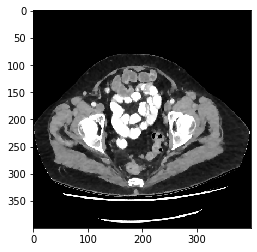

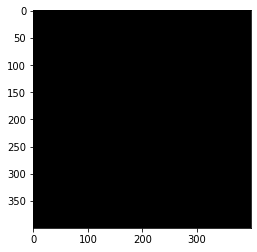

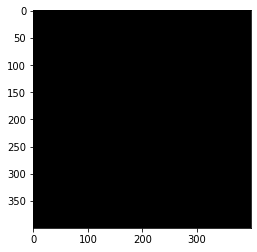

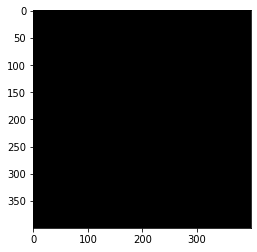

100.0
The slice  172


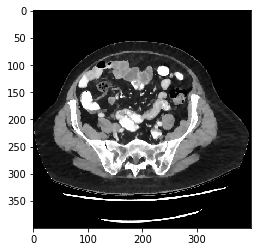

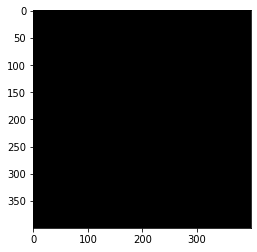

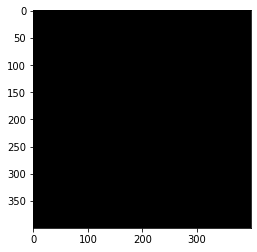

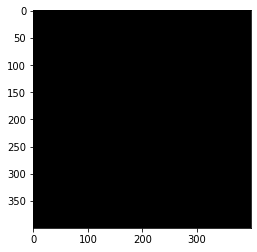

100.0
The slice  285


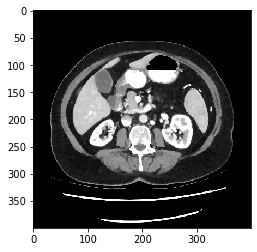

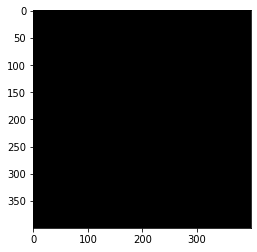

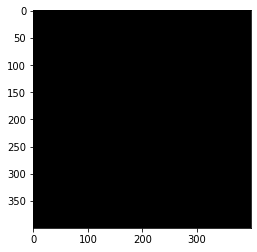

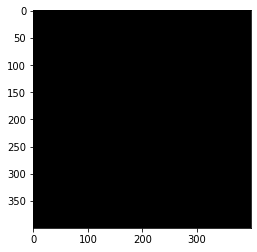

100.0
VOE =  99.99999999965326
Dice =  3.4674063800157165e-10


In [0]:
VOE,Dice,predict_img=predict_image(img_path,gt_path,
              checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model18/best_valid_model18_ver2.hdf5",
              threshold=0.98,evaluate=True,show_slice=[100,172,285],verbose=True
              )

## Evaluate cnn model in validation data



In [0]:
img_path=glob.glob("/content/drive/My Drive/Dataset2/resample_data/volum*")
gt_path=glob.glob("/content/drive/My Drive/Dataset2/resample_data/segme*")
img_path.sort()
gt_path.sort()

### last model 14: Dice 43

In [16]:
evaluate_model(img_path[105:131],gt_path[105:131],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/last_model14.hdf5",threshold=0.9, verbose=True,save_dir="/content/drive/My Drive/Luan Van 2019/Tumor/log/")

Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-106.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-106.nii.gz
original_size (432, 432, 690)
scan_arr size (576, 576, 704)
99/99 [==============================] - 10s 99ms/sample
original_size (432, 432, 690)
scan_arr size (448, 448, 704)
539/539 [==============================] - 11s 20ms/sample
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-107.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-107.nii.gz
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
40/40 [==============================] - 7s 168ms/sample
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
360/360 [==============================] - 9s 25ms/sample
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-108.nii.gz
original_size (400, 400, 617)
scan_arr size (5

45.931153846153855

In [0]:
evaluate_model(img_path[105:131],gt_path[105:131],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/best_valid_model14.hdf5",threshold=0.9, verbose=True,save_dir="/content/drive/My Drive/Luan Van 2019/Tumor/log/")

Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-106.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-106.nii.gz
original_size (432, 432, 690)
scan_arr size (576, 576, 704)
99/99 [==============================] - 15s 150ms/sample
original_size (432, 432, 690)
scan_arr size (448, 448, 704)
539/539 [==============================] - 17s 32ms/sample
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-107.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-107.nii.gz
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
40/40 [==============================] - 12s 292ms/sample
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
360/360 [==============================] - 15s 41ms/sample
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-108.nii.gz
original_size (400, 400, 617)
scan_arr size

In [0]:
evaluate_model(img_path[105:131],gt_path[105:131],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model18/best_valid_model18_ver2.hdf5",threshold=0.9, verbose=True)

### Best valid model 14_ver2_61: Dice 32

1.   List item
2.   List item



In [0]:
evaluate_model(img_path[105:131],gt_path[105:131],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model21/last_model21_ver2.hdf5",threshold=0.8, verbose=True)

a
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-106.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-106.nii.gz
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
original_size (432, 432, 690)
scan_arr size (576, 576, 704)
99/99 [==============================] - 18s 183ms/sample
original_size (432, 432, 690)
scan_arr size (448, 448, 704)
539/539 [==============================] - 7s 13ms/sample
1.82815356486603e-09
a
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-107.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-107.nii.gz
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
40/40 [==============================] - 4s 92ms/sample
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
360/360 [==============================] - 5s 14ms/sample
100.0
a
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz
Load mask:  /con

In [0]:
evaluate_model(img_path[105:131],gt_path[105:131],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weights_model14/best_valid_model14_ver2_61.hdf5",threshold=0.9, verbose=True)

### Unet best valid 64: 43,7

In [0]:
img_path=glob.glob("/content/drive/My Drive/Dataset2/resample_data/volum*")
gt_path=glob.glob("/content/drive/My Drive/Dataset2/resample_data/segme*")
img_path.sort()
gt_path.sort()

In [0]:
evaluate_model_unet(img_path[105:],gt_path[105:],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weight_unet/best_valid_unet_64.hdf5",
               threshold=0.80, verbose=True)

Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-106.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-106.nii.gz
original_size (432, 432, 690)
scan_arr size (448, 448, 704)
539/539 [==============================] - 15s 27ms/sample
original_size (432, 432, 690)
scan_arr size (576, 576, 704)
99/99 [==============================] - 7s 69ms/sample
100.0
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-107.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-107.nii.gz
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
360/360 [==============================] - 11s 30ms/sample
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
40/40 [==============================] - 4s 102ms/sample
100.0
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-108.nii.gz
original_size (400, 400, 617)
scan

### Unet best valid: 34. Dice: 47 if skip the predict <500

In [0]:
evaluate_model_unet(img_path[105:],gt_path[105:],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weight_unet/best_valid_unet.hdf5",
               threshold=0.80, verbose=True)

Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-106.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-106.nii.gz
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
original_size (432, 432, 690)
scan_arr size (448, 448, 704)
539/539 [==============================] - 49s 92ms/sample
original_size (432, 432, 690)
scan_arr size (576, 576, 704)
99/99 [==============================] - 17s 169ms/sample
2.2988505746597967e-09
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-107.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-107.nii.gz
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
360/360 [==============================] - 31s 85ms/sample
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
40/40 [==============================] - 6s 145ms/sample
7.142857137755102e-08
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz
L

In [0]:
evaluate_model_unet(img_path[105:],gt_path[105:],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weight_unet/best_valid_unet.hdf5",
               threshold=0.80, verbose=True)

Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-106.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-106.nii.gz
original_size (432, 432, 690)
scan_arr size (448, 448, 704)
539/539 [==============================] - 14s 25ms/sample
original_size (432, 432, 690)
scan_arr size (576, 576, 704)
99/99 [==============================] - 7s 67ms/sample
pixel in list 435.0
100.0
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-107.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-107.nii.gz
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
360/360 [==============================] - 10s 27ms/sample
original_size (373, 373, 617)
scan_arr size (384, 384, 640)
40/40 [==============================] - 3s 73ms/sample
pixel in list 14.0
100.0
Load image:  /content/drive/My Drive/Dataset2/resample_data/volume-108.nii.gz
Load mask:  /content/drive/My Drive/Dataset2/resample_data/segmentation-108.nii

In [0]:
evaluate_model_unet(img_path[105:],gt_path[105:],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Tumor/weights/weight_unet/best_valid_unet.hdf5",
               threshold=0.80, verbose=True)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
66


### Evaluate unet model for LITS validation data

In [0]:

evaluate_model_unet(img_path[101:],gt_path[101:],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Liver/weights/weights_unet/w_model_lits2.hd5",
               threshold=0.80, verbose=True)

Load image:  /content/drive/My Drive/DataSet/Nii_data_resample_spacing/volume-102.nii.gz
Load mask:  /content/drive/My Drive/DataSet/normalize_data/segmentation-102.nii.gz
original_size (361, 361, 478)
scan_arr size (384, 384, 512)
32/32 [==============================] - 27s 847ms/sample
Load image:  /content/drive/My Drive/DataSet/Nii_data_resample_spacing/volume-103.nii.gz
Load mask:  /content/drive/My Drive/DataSet/normalize_data/segmentation-103.nii.gz
original_size (367, 367, 474)
scan_arr size (384, 384, 512)
32/32 [==============================] - 26s 800ms/sample
Load image:  /content/drive/My Drive/DataSet/Nii_data_resample_spacing/volume-104.nii.gz
Load mask:  /content/drive/My Drive/DataSet/normalize_data/segmentation-104.nii.gz
original_size (438, 438, 478)
scan_arr size (576, 576, 512)
72/72 [==============================] - 49s 685ms/sample
Load image:  /content/drive/My Drive/DataSet/Nii_data_resample_spacing/volume-105.nii.gz
Load mask:  /content/drive/My Drive/DataS

### Evaluate unet model for Sliver validation data


In [0]:
img_path2=glob.glob("/content/drive/My Drive/DataSet/normalize_data/sliver/volu*")
gt_path2=glob.glob("/content/drive/My Drive/DataSet/normalize_data/sliver/segme*")
img_path2.sort()
gt_path2.sort()

In [0]:
evaluate_model_unet(img_path2[16:],gt_path2[16:],
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Liver/weights/weights_unet/w_model_sliver2.hd5",
               threshold=0.80, verbose=True)

Load image:  /content/drive/My Drive/DataSet/normalize_data/sliver/volume-017.nii.gz
Load mask:  /content/drive/My Drive/DataSet/normalize_data/sliver/segmentation-017.nii.gz
original_size (350, 350, 242)
scan_arr size (384, 384, 256)
16/16 [==============================] - 20s 1s/sample
Load image:  /content/drive/My Drive/DataSet/normalize_data/sliver/volume-018.nii.gz
Load mask:  /content/drive/My Drive/DataSet/normalize_data/sliver/segmentation-018.nii.gz
original_size (379, 379, 245)
scan_arr size (384, 384, 256)
16/16 [==============================] - 20s 1s/sample
Load image:  /content/drive/My Drive/DataSet/normalize_data/sliver/volume-019.nii.gz
Load mask:  /content/drive/My Drive/DataSet/normalize_data/sliver/segmentation-019.nii.gz
original_size (313, 313, 234)
scan_arr size (384, 384, 256)
16/16 [==============================] - 20s 1s/sample
Load image:  /content/drive/My Drive/DataSet/normalize_data/sliver/volume-020.nii.gz
Load mask:  /content/drive/My Drive/DataSet/n

### Evaluate unet model for 3Dircadb validation data

In [0]:
img_path3=glob.glob("/content/drive/My Drive/DataSet/normalize_data/3dircab/volu*")
gt_path3=glob.glob("/content/drive/My Drive/DataSet/normalize_data/3dircab/segme*")
img_path3.sort()
gt_path3.sort()

In [0]:
evaluate_model_unet(img_path3,gt_path2,
               checkpoint_path="/content/drive/My Drive/Luan Van 2019/Liver/weights/weights_unet/w_model_l.hd5",
               threshold=0.80, verbose=True)

# Draft

In [0]:
# read image
  image_itk3 = sitk.ReadImage("/content/drive/My Drive/DataSet/Nii_data_resample_spacing/volume-011.nii.gz")
  img_array3= sitk.GetArrayFromImage(image_itk3)
  image_arr3 = np.moveaxis(img_array3,0,-1)

  gt_itk3 = sitk.ReadImage("/content/drive/My Drive/DataSet/Nii_data_resample_spacing/segmentation-011.nii.gz")
  gt_array3= sitk.GetArrayFromImage(gt_itk3)
  gt_arr3 = np.moveaxis(gt_array3,0,-1)

In [0]:
model = cnn.CNN(size=(192,192,64),number_initial_filter = 16, output_activation_name='sigmoid', is_training = False,checkpoint_path = "/content/drive/My Drive/Luan Van 2019/LVTN/weights/weights_last_model1_kiet1107_ver2.hdf5")
full_img=predict_Sample(image_arr3, model, target_size=(192,192,64), batch_size=1, verbose = True)

original_size (394, 394, 501)
scan_arr size (576, 576, 512)
72/72 [==============================] - 5s 67ms/sample


In [0]:
print(full_img.shape)
print(image_arr3.shape)
print(gt_arr3.shape)
print("max predict :",full_img.max())
print("min predict :",full_img.min())
print(gt_arr3.max())
print(image_arr3.max())
full_img[full_img>=0.88]=1.
full_img[full_img<0.88]=0.

(394, 394, 501)
(394, 394, 501)
(394, 394, 501)
max predict : 0.9671889
min predict : 1.1324883e-06
1
1.0


In [0]:
print(full_img[:,:,351].max())

1.0


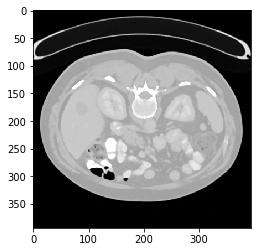

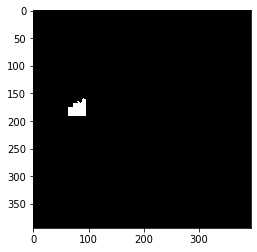

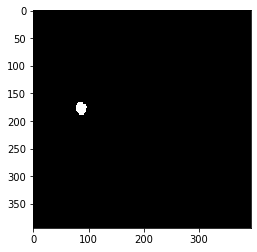

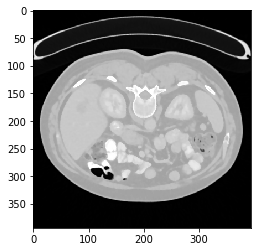

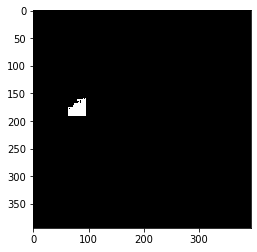

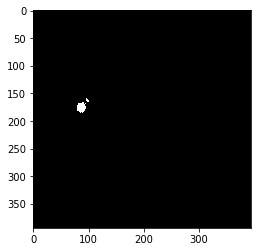

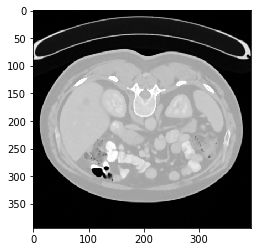

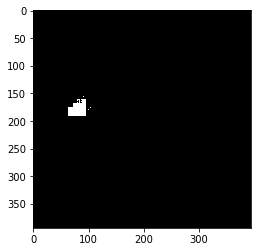

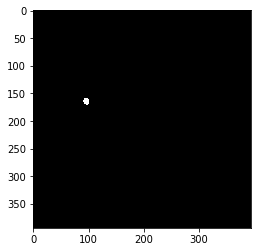

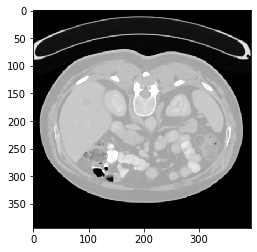

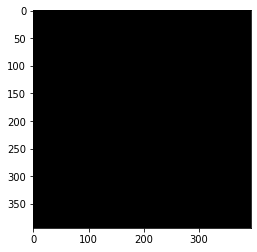

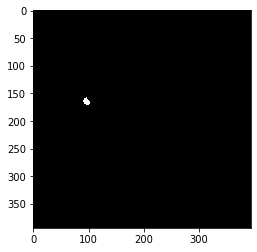

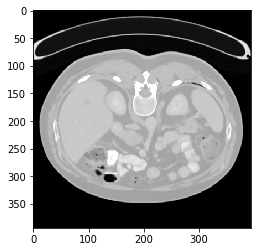

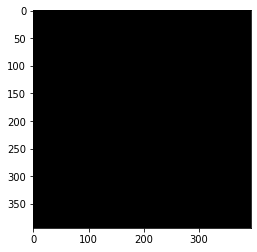

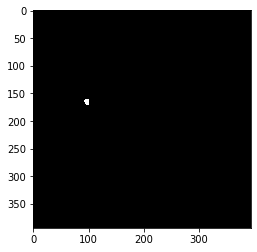

In [0]:
for i in range(5):
  print("===================================")
  plt.imshow(image_arr3[:,:,345+ 3*i],cmap="gray")
  plt.show()
  plt.imshow(full_img[:,:,345+ 3*i],cmap="gray")
  plt.show()
  plt.imshow(gt_arr3[:,:,345+ 3*i],cmap="gray")
  plt.show()

In [0]:
from util.evaluate_model_tools import *
a=compute_VOE(gt_arr3,full_img)
print(a)

78.18025010776763


In [0]:
print(compute_DICE(gt_arr3,full_img))

35.82300884958276


In [0]:
print(compute_VOE(gt_arr3,full_img))

78.18025010776763


In [0]:
a=[[1.,0.],[1.,0.],[0.,0.]]
b=[[1.,1.],[1.,0.],[1.,0.]]

print(compute_DICE(np.asarray(b),np.asarray(a)))

66.66666672222222


# Draw model

In [0]:
listLoss=[]
listScoreVOE=[]
list_val_croreVOE=[]
list_val_loss=[]
import csv
with open('/content/drive/My Drive/Luan Van 2019/Liver/log_model1 _total.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        listLoss.append(row[1])
        listScoreVOE.append(row[12])
        list_val_croreVOE.append(row[25])
        list_val_loss.append(row[15])
csvFile.close()
print(listLoss)
print(listScoreVOE)
print(list_val_croreVOE)
epoch=[x for x in range(len(listLoss)-1)]

['loss', '10.2424821842284', '9.0450399213367', '7.53888731721848', '4.69104695045759', '3.63137021632422', '2.96135822766357', '2.53343312376075', '2.27190141029774', '2.12293086539185', '2.02293041531234', '1.89293082367717', '1.82293086539233', '1.75293086236161', '1.62313086532343', '1.52293086539185', '1.42293086539185', '1.42293086539185', '1.32293086539185', '1.12293086539185', '0.92293086539185']
['score_main_VOE', '0.81175387', '0.6299341', '0.5449948', '0.417969', '0.4015947', '0.39549035', '0.38200344', '0.37293344', '0.35388899', '0.33323424', '0.32380244', '0.30382442', '0.27382442', '0.25380244', '0.22380124', '0.22380234', '0.20382333', '0.18380193', '0.19380135', '0.19280443']
['val_score_main_VOE', '0.7142331', '0.6097016', '0.471982', '0.39673215', '0.3841964', '0.39549035', '0.38200344', '0.36293344', '0.36448899', '0.35323424', '0.32380244', '0.31382442', '0.28382442', '0.24380244', '0.23380124', '0.22380234', '0.21382333', '0.19380193', '0.16380135', '0.15280443']


In [0]:
listLoss=[ float(x) for x in listLoss[1:]]
listScoreVOE=[float(x) for x in listScoreVOE[1:]]
list_val_croreVOE=[float(x) for x in list_val_croreVOE[1:]]

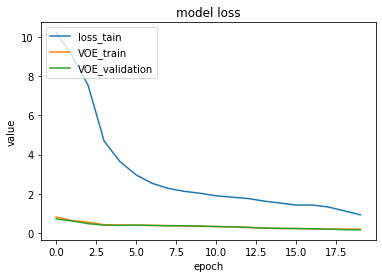

In [0]:
plt.plot(epoch,listLoss,label="Loss")
plt.plot(epoch,listScoreVOE,label="Score")
plt.plot(epoch,list_val_croreVOE,label="Score")
plt.title('model loss')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['loss_tain','VOE_train','VOE_validation'], loc='upper left')
plt.show()